In [65]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as crs
import cartopy
from cmocean import cm
import os
import regionmask
import pandas as pd
import seaborn as sns

from shapely.geometry import Polygon, MultiPolygon  # In order to consider the rest of the world as source region
from shapely.ops import unary_union

from Functions import * 
from combine_data import *

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

# Data loading

In [66]:
basedir = "../data/"
casename = "Australia"
srcs = read_data(basedir, casename)

Loading wam2layers data for Australia
Loading 2ldrm data for Australia
Loading utrack data for Australia
Loading B-TrIMS data for Australia
Loading tracmass data for Australia
Loading ughent data for Australia
Loading UIB data for Australia
Loading UniVie data for Australia
Loading CHc data for Australia
Loading xu data for Australia
Loading tatfancheng data for Australia
Loading uvigo data for Australia
Loading WRF-WVT data for Australia


In [67]:
### Calculate (area weighted) fractional sources ###
srcs_frac = calc_fractional_sources(srcs)

## CMIP REGIONS

['N.Australia', 'C.Australia', 'E.Australia', 'S.Australia', 'New-Zealand', 'Equatorial.Pacific-Ocean', 'S.Pacific-Ocean', 'Southern-Ocean']


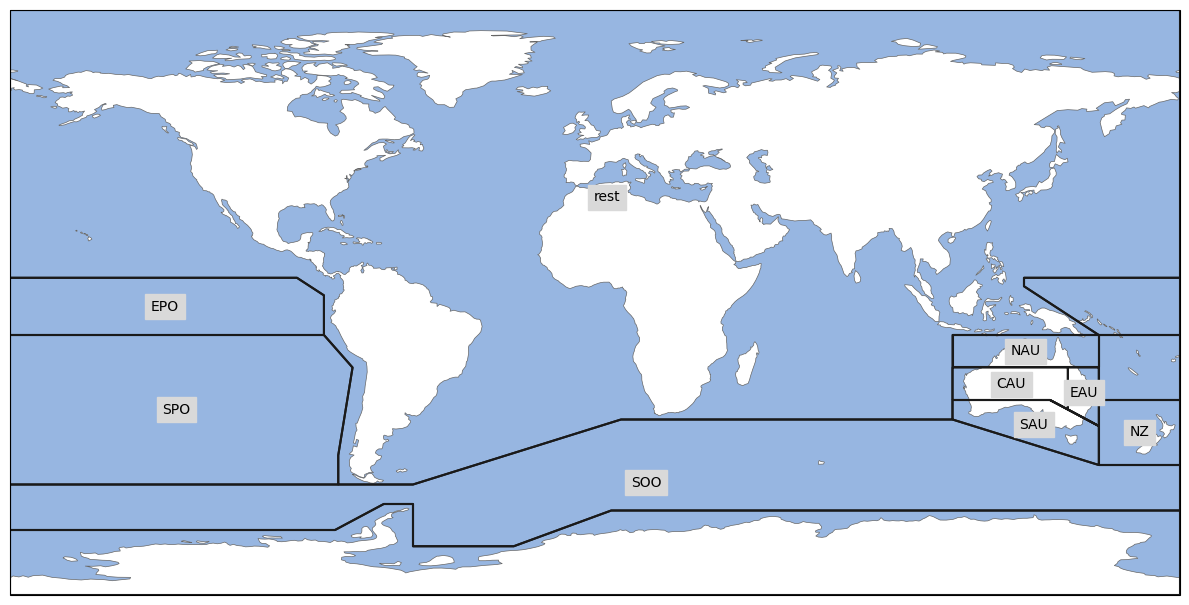

In [68]:
'''Define regions, also provides an example how to define them using the regionmask package. 

Now 'rest of the world', as well as the 'event' or 'sink' region, are also defined using the
same package.
'''

#### Sources per region, import necessary libraries ####
my_projection = crs.PlateCarree(central_longitude=0)

if casename=="Pakistan":
    regions_list = ["NEAF", "SEAF", "WCA", "TIB", "ARP", "SAS", "ARS", "BOB", "EIO", "SIO"]
    boxfile = basedir+casename+f"/Mask_PakistanFlood_box_lon-180to180.nc"
    sink_da = xr.open_dataset(boxfile)['mask']
else:
    if casename=="Scotland":
        regions_list = ["ENA", "CAR", "NEU", "WCE", "MED", "NAO"]
        boxfile = basedir+casename+f"/mask_scotland_box_lon-180to180.nc"
    elif casename=="Australia":
        regions_list = ["NAU", "CAU", "EAU", "SAU", "NZ", "EPO", "SPO", "SOO"]
        boxfile = basedir+casename+f"/mask_australia_box_lon-180to180.nc"
    sink_da = xr.open_dataset(boxfile)['mask'].isel(time=0)

ar6_all = regionmask.defined_regions.ar6.all
selected_regions = ar6_all[regions_list]
print(selected_regions.names) #Print name of the different regions

# Create region representing the rest of the world
ipcc_union = unary_union(selected_regions.polygons)
global_box_coords = [(-180, -90), (180, -90), (180, 90), (-180, 90)]
global_polygon = Polygon(global_box_coords)
complementary_polygon = global_polygon.difference(ipcc_union)
comp_region = regionmask.Regions([complementary_polygon], names=['rest'], abbrevs=['rest'])

# Merge the IPCC regions and the rest of the world in selected_regions
selected_regions = regionmask.Regions([*selected_regions.polygons, *comp_region.polygons],\
    names=[*selected_regions.names, *comp_region.names],\
    abbrevs=[*selected_regions.abbrevs, *comp_region.abbrevs],\
    numbers=[*selected_regions.numbers, *(np.array(comp_region.numbers) + max(selected_regions.numbers) + 1)])

# Visualize the regions
plt.figure(figsize=(12,8))
ax = plt.axes(projection=my_projection)
ax.set_extent([-180., 180., -90., 90.])
ax = selected_regions.plot(ax=ax, label="abbrev", add_ocean=True)
plt.tight_layout()
plt.savefig(casename+"Regions.png")

# Create also another region representing the sink box and add it
sink_lats = sink_da.lat[np.where(sink_da.values>0)[0]]
sink_lons = sink_da.lon[np.where(sink_da.values>0)[1]]        
latmin = sink_lats.min(); latmax = sink_lats.max()
lonmin = sink_lons.min(); lonmax = sink_lons.max()
sink_polygon = Polygon([(lonmin, latmin), (lonmax, latmin), (lonmax, latmax), (lonmin, latmax)])
sink_region = regionmask.Regions([sink_polygon], names=['sink'], abbrevs=['sink'])
all_regions = regionmask.Regions([*selected_regions.polygons, *comp_region.polygons, *sink_region.polygons],\
    names=[*selected_regions.names, *comp_region.names, *sink_region.names],\
    abbrevs=[*selected_regions.abbrevs, *comp_region.abbrevs, *sink_region.abbrevs],\
    numbers=[*selected_regions.numbers, *(np.array(comp_region.numbers) + max(selected_regions.numbers) + 1),\
                                        *(np.array(sink_region.numbers) + max(selected_regions.numbers) + 1)])
sink_da.close()

## Regional sources

In [69]:
''' 
Here we can choose if we want to plot also the fraction of moisture coming from the sink region (add_sink=True)
For WRF-WVT, we need to compute it separately, as it corresponds to another tagging experiment
'''

## Calculation of fractions of moisture coming from the selected regions (in %)
add_sink = False
if add_sink==True:
    srcs_regional, weights = calc_regional_sources(srcs_frac, all_regions)
    ds = xr.open_dataset(basedir+casename+"/results WRF-WVT/"+casename+"_Rain-TracerRain.nc")
    frac = np.sum(ds.tr_rain.values*ds.trmask.values)/np.sum(ds.rain.values*ds.trmask.values)*100
    srcs_regional['WRF-WVT'] = xr.where(srcs_regional['names']=='sink', frac, srcs_regional['WRF-WVT'])
else:
    srcs_regional, weights = calc_regional_sources(srcs_frac, selected_regions)

/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


In [70]:
''' 
We create a data frame in which each row corresponds to a single method and region. We also define model names and group
different ensemble members for the same method together. So far only for UTrack, HAMSTER and FLEXPART-WaterSip (TFC) there
are more ensemble members than the default one.
'''

# Create a data frame with the results for plotting
models = [var for var in srcs_regional.data_vars]
names = [model[:model.find('Ens')].rstrip(' ') if 'Ens' in model else model for model in models]
regions = srcs_regional.region.names.values
values = srcs_regional[models].to_array().values.flatten()
nmodels = len(models); nregions = len(regions)
df = pd.DataFrame({'value': values, 'region': np.tile(regions, nmodels),\
                   'model': np.repeat(models, nregions), 'name': np.repeat(names, nregions)})

# Add a column for identifying additional ensemble members
def_members = ['UTrack Ens2', 'FLEXPART-HAMSTER Ens5', 'FLEXPART-WaterSip (TFC) Ens1']
add_members = [model for model in models if 'Ens' in model and model not in def_members]
df['ens'] = [1 if model in add_members  else 0 for model in df['model']]

## Figures

/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease 

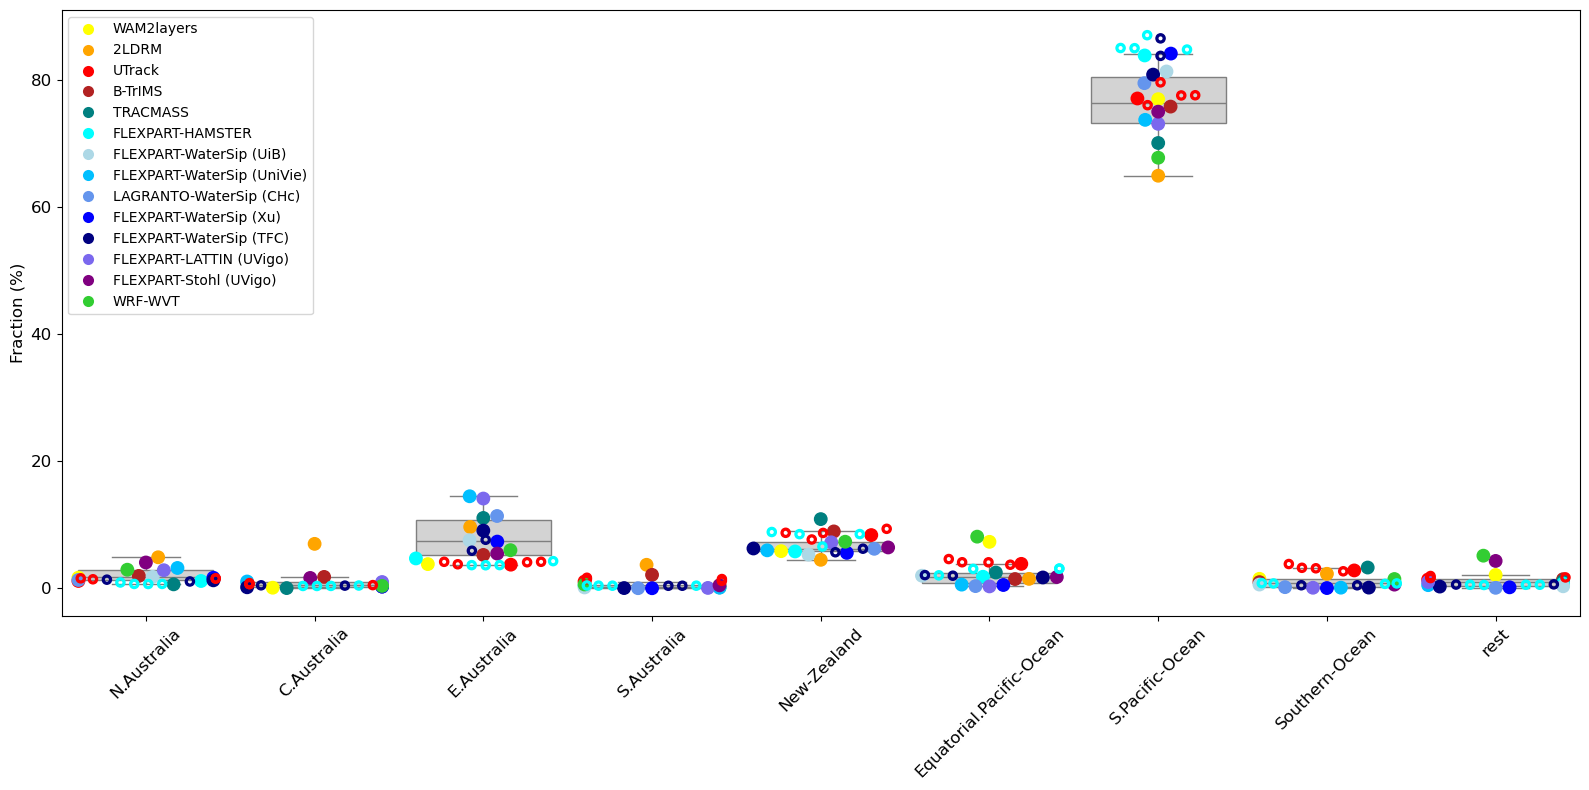

In [71]:
''' 
We use a beeswarm plot, which prevents points from overlapping. Howver, the beeswarm function in the seaborn library does not allow
to use different markers to distinguish the default from the ensemble members, so we get the positions and use a scatter plot.
Then we add a boxplot to highlight the multimethod mean. Observe that only de default ensemble members are used in the boxplot.
'''

# Assign a color for each model
colors = {'WAM2layers': 'yellow', '2LDRM': 'orange', 'UTrack': 'red', 'B-TrIMS': 'firebrick', 'TRACMASS': 'teal', 'FLEXPART-HAMSTER': 'cyan',\
          'FLEXPART-WaterSip (UiB)': 'lightblue', 'FLEXPART-WaterSip (UniVie)': 'deepskyblue', 'LAGRANTO-WaterSip (CHc)': 'cornflowerblue',\
          'FLEXPART-WaterSip (Xu)': 'blue', 'FLEXPART-WaterSip (TFC)': 'navy', 'FLEXPART-LATTIN (UVigo)': 'mediumslateblue',\
          'FLEXPART-Stohl (UVigo)': 'purple', 'WRF-WVT': 'limegreen'}

# Create the figure
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

# Create swarmplot and hide it (with this function we cannot use different markers)
sw = sns.swarmplot(data=df, x=df['region'], y=df['value'], hue=df['name'], palette=colors, size=8)
legend = sw.get_legend()

# Get the positions and create a new data frame with the information we need
x = []; y = []
for coll in sw.collections:
    data = coll.get_offsets()
    x.append(data[:,0]), y.append(data[:,1])

x = np.array(x); y = np.array(y)
sw.collections.clear()

order_df = df[['region', 'model']].values.tolist()
order_xy = np.array([np.repeat(regions, len(models)), np.tile(models, nregions)]).transpose().tolist()
order = [order_xy.index(item) for item in order_df]
df['x'] = x.flatten()[order]; df['y'] = y.flatten()[order]
df['color'] = [colors[name] for name in df['name']]

# Now plot
df1 = df[df['ens']==0.]
plt.scatter(df1['x'], df1['y'], s=80, c=df1['color'].values.tolist())
df2 = df[df['ens']==1.]
plt.scatter(df2['x'], df2['y'], s=100, c=df2['color'].values.tolist(), marker='$\circ$')

# Add boxplot
sns.boxplot(data=df1, x=df1['region'], y=df1['value'], color='lightgrey', fliersize=0, zorder=0)

# Legend
legend = sw.get_legend()
sns.move_legend(sw, loc='upper left')
legend.set_title('Models')
plt.setp(legend.get_texts(), fontsize=12)
plt.setp(legend.get_title(), fontsize=12)

# Labels and ticks
ax.set_xticks(np.arange(nregions))
ax.set_xticklabels(srcs_regional.names.values, rotation=45, size=12)
ax.set_xlabel('')
ax.set_ylabel('Fraction (%)', size=12)
ax.tick_params('y', labelsize=12)

plt.tight_layout()

# Save figure
if add_sink==False:
    figname = f"BeeswarmAndBoxPlot-WihtouSink_{casename}.png"
else:
    figname = f"BeeswarmAndBoxPlot_{casename}.png"

plt.savefig(figname, dpi=600, bbox_inches='tight')

/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease 

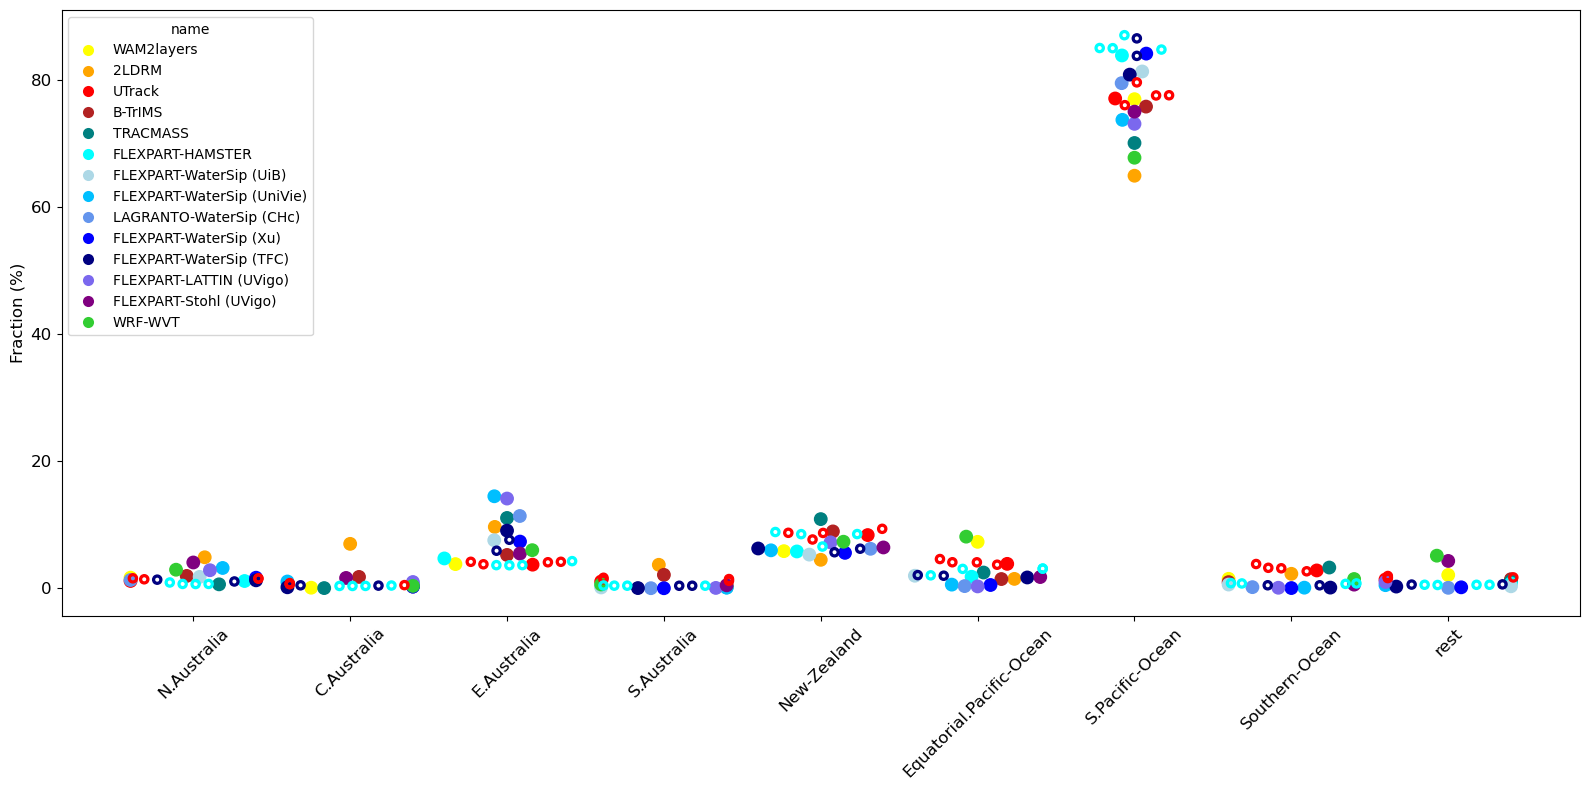

In [72]:
# Only beeswarm
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
sw = sns.swarmplot(data=df, x=df['region'], y=df['value'], hue=df['name'], palette=colors, size=8)
legend = sw.get_legend()
sw.collections.clear()
plt.scatter(df1['x'], df1['y'], s=80, c=df1['color'].values.tolist())
plt.scatter(df2['x'], df2['y'], s=100, c=df2['color'].values.tolist(), marker='$\circ$')

# Legend
legend = sw.get_legend()
sns.move_legend(sw, loc='upper left')
legend.set_title('Models')
plt.setp(legend.get_texts(), fontsize=12)
plt.setp(legend.get_title(), fontsize=12)

# Labels and ticks
ax.set_xticks(np.arange(nregions))
ax.set_xticklabels(srcs_regional.names.values, rotation=45, size=12)
ax.set_xlabel('')
ax.set_ylabel('Fraction (%)', size=12)
ax.tick_params('y', labelsize=12)

plt.tight_layout()

# Save figure
if add_sink==False:
    figname = f"BeeswarmPlot-WithoutSink_{casename}.png"
else:
    figname = f"BeeswarmPlot_{casename}.png"

plt.savefig(figname, dpi=600, bbox_inches='tight')